In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from scipy.io import loadmat
from os.path import basename
import numpy as np
from scipy import ndimage

In [3]:


def getLarea(input_mask):
    try:
        labeled_mask, cc_num = ndimage.label(input_mask)
        mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
    except:
        mask = input_mask
    return mask

def getkvgh(matfile):
    mat = loadmat(matfile)
    BMAstr = basename(matfile).split('.')[0][-1]
    T1map = mat['%s_T1map_pre' % BMAstr]
    imapre = mat['%s_im_pre' % BMAstr]
    LVb = mat['%s_inner' % BMAstr]
    LVw = mat['%s_LV_wall_non' % BMAstr]
    RVb = mat['%s_heart' % BMAstr] & np.logical_not(mat['%s_outer' % BMAstr])
    RVb = getLarea(RVb)
    labelimg = (LVb*0).astype(np.uint16)
    labelimg[np.nonzero(LVb)] = 3
    labelimg[np.nonzero(LVw)] = 2
    labelimg[np.nonzero(RVb)] = 1
    omatsize = T1map.shape
    return T1map, imapre, labelimg, omatsize

In [4]:
T1map, imapre, labelimg, omatsize = getkvgh(r'C:\TudoCD\T-995835-20151229_B.mat')
lvb = labelimg
LVbmask = (lvb==3)
LVwmask = (lvb==2)
RVbmask = (lvb==1)


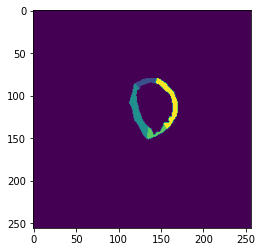

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymr.heart import ahaseg
heart_mask = (LVbmask, LVwmask, RVbmask)
label_mask = ahaseg.get_seg(heart_mask, nseg=4)
plt.imshow(label_mask)

In [ ]:

plt.imshow(label_mask)

In [ ]:
import numpy as np
from scipy import ndimage

def degree_calcu(UP, DN, seg_num):
    anglelist = np.zeros(seg_num)
    if seg_num == 4:
        anglelist[0] = DN-180.
        anglelist[1] = UP
        anglelist[2] = DN
        anglelist[3] = UP+180.

    if seg_num == 6:
        anglelist[0] = DN-180.
        anglelist[1] = UP
        anglelist[2] = (UP+DN)/2.
        anglelist[3] = DN
        anglelist[4] = UP+180.
        anglelist[5] = anglelist[2]+180.
    anglelist = (anglelist + 360) % 360

    return anglelist.astype(int)

def circular_sector(r_range, theta_range, LV_center):
    cx, cy = LV_center
    theta = theta_range/180*np.pi
    z = r_range.reshape(-1, 1).dot(np.exp(1.0j*theta).reshape(1, -1))
    xall = -np.imag(z) + cx
    yall = np.real(z) + cy
    return xall, yall

def get_theta(sweep360):
    from scipy.optimize import curve_fit
    from scipy.signal import medfilt
    sumar = np.array(sweep360)
    x = np.arange(sumar.size)
    y = sumar
    maxv = np.argmax(y)
    y = medfilt(y)

    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    def fit(x, y):
        p0 = [np.max(y), np.argmax(y)+x[0], 1.]
        try:
            coeff, var_matrix = curve_fit(gauss, x, y, p0=p0)
            A, mu, sigma = coeff
        except:
            mu = 0
            sigma = 0
        return mu, sigma

    mu, sigma = fit(x[:maxv], y[:maxv])
    uprank1 = mu - sigma*2.5
    mu, sigma = fit(x[maxv:], y[maxv:])
    downrank1 = mu + sigma*2.5
    if downrank1 == 0:
        downrank1 = 360

    uprank2 = np.nonzero(y > 5)[0][0]
    downrank2 = np.nonzero(y > 5)[0][-1]
    uprank = max(uprank1, uprank2)
    downrank = min(downrank1, downrank2)

    return int(uprank), int(downrank)

def get_sweep360(LVwmask, RVbmask):

    LV_center = ndimage.center_of_mass(LVwmask)
    rr = np.min(np.abs(LVwmask.shape-np.array(LV_center))).astype(np.int)

    sweep360 = []
    for theta in range(360):
        #print(theta)
        xall, yall = circular_sector(np.arange(0, rr, 0.5),
                                     theta, LV_center)
        projection = ndimage.map_coordinates(RVbmask, [xall, yall], order=0).sum()
        sweep360.append(projection)
    return np.array(sweep360)


def get_angle(heart_mask, nseg=4):
    def sector_mask(xall, yall, LVwmask):
        smask = LVwmask * 0
        xall = np.round(xall.flatten())
        yall = np.round(yall.flatten())

        mask = (xall >= 0) & (yall >= 0) & \
               (xall < LVwmask.shape[0]) & (yall < LVwmask.shape[1])
        xall = xall[np.nonzero(mask)].astype(int)
        yall = yall[np.nonzero(mask)].astype(int)
        smask[xall, yall] = 1
        return smask
    
    #step 1: sweep 360 and get AHA angles
    
    LVbmask, LVwmask, RVbmask = heart_mask
    #import time
    #t = time.time()
    sweep360 = get_sweep360(LVwmask, RVbmask)
    UP, DN = get_theta(sweep360)
    anglelist = degree_calcu(UP, DN, nseg)
    
    #step 2: calculate mask360, 360 points with AHA labels

    angles2 = np.append(anglelist, anglelist[0])
    angles2 = np.rad2deg(np.unwrap(np.deg2rad(angles2)))
    mask360 = np.zeros((360, ))
    for ii in range(angles2.size-1):
        temp = np.arange(angles2[ii], angles2[ii + 1]).astype(np.int)
        temp[temp >= 360] = temp[temp >= 360] - 360
        mask360[temp] = ii + 1
        
    #step 3: calculating AHA sector
    LV_center = ndimage.center_of_mass(LVwmask)
    AHA_sector = LVwmask * 0
    rr = np.min(np.abs(LVwmask.shape-np.array(LV_center))).astype(np.int)


    for ii in range(angles2.size-1):
        xall, yall = circular_sector(np.arange(0, rr, 0.5),
                                     np.arange(angles2[ii], angles2[ii+1],
                                     0.5), LV_center)
        smask = sector_mask(xall, yall, LVwmask)
        
        AHA_sector[smask > 0] = (ii + 1)
        
    
    return anglelist, mask360, AHA_sector
#print(time.time() - t)
#plt.figure()
#plt.imshow(label_mask)

def get_seg(heart_mask, nseg=4):
    LVbmask, LVwmask, RVbmask = heart_mask

    _, _, AHA_sector = get_angle(heart_mask, nseg)
    #label_mask = labelit(anglelist, LVwmask)
    label_mask = AHA_sector * LVwmask

    return label_mask

def get_thick(heart_mask, nseg):
    LVbmask, LVwmask, RVbmask = heart_mask
    
    _, mask360, _ = get_angle(heart_mask, nseg)
    sweep360 = get_sweep360(LVwmask, LVwmask)
    thick_list = []
    for ii in range(nseg):
        thick_list.append(np.mean(sweep360[mask360 == (ii + 1)]))
    
    return np.array(thick_list)

def get_thickmap(LVwmask):

    LV_center = ndimage.center_of_mass(LVwmask)
    rr = np.min(np.abs(LVwmask.shape-np.array(LV_center))).astype(np.int)
    thickmap = LVwmask * 0

    sweep360 = []
    for theta in range(360):
        #print(theta)
        xall, yall = circular_sector(np.arange(0, rr, 0.5),
                                     theta, LV_center)
        projection = ndimage.map_coordinates(LVwmask, [xall, yall], order=0).sum()
        thickmap[xall.astype(np.int), yall.astype(np.int)] = projection
        
        sweep360.append(projection)
    thickmap = LVwmask * thickmap
    return thickmap

def get_thickmap_mean(label_mask, thick):
    thickmap_mean = label_mask.copy()
    for ii in range(4):
        thickmap_mean[thickmap_mean == (ii+1)] = thick[ii]
        
    return thickmap_mean
    

LVbmask = (lvb==3)
LVwmask = (lvb==2)
RVbmask = (lvb==1)
heart_mask = (LVbmask, LVwmask, RVbmask)

label_mask = get_seg(heart_mask, nseg=6)
thickmap = get_thickmap(LVwmask)
thick = get_thick(heart_mask, nseg=6)
thickmap_mean = get_thickmap_mean(label_mask, thick)



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(labelimg)
plt.figure()
plt.imshow(label_mask)
plt.figure()
plt.imshow(thickmap)
plt.figure()
plt.imshow(thickmap_mean)
print(thick)

In [ ]:
thick

In [ ]:
def get_thick(LVbmask, LVwmask, RVbmask, nseg):
    anglelist = get_angle(LVbmask, LVwmask, RVbmask, nseg)
    sweep360 = np.array(get_sweep360(LVwmask, LVwmask))
    angles2 = np.append(anglelist, anglelist[0])
    angles2 = np.rad2deg(np.unwrap(np.deg2rad(angles2)))
    thick_list = []
    for ii in range(angles2.size-1):
        temp = np.arange(angles2[ii], angles2[ii + 1]).astype(np.int)
        temp[temp >= 360] = temp[temp >= 360] - 360
        thick_list.append(temp)
    
    return np.array(thick_list)
    

In [ ]:
sweep360

In [ ]:
anglelist

In [ ]:
def get_thickmap(LVwmask):

    LV_center = ndimage.center_of_mass(LVwmask)
    rr = np.min(np.abs(LVwmask.shape-np.array(LV_center))).astype(np.int)
    thickmap = LVwmask * 0

    sweep360 = []
    for theta in range(360):
        #print(theta)
        xall, yall = circular_sector(np.arange(0, rr, 0.5),
                                     theta, LV_center)
        projection = ndimage.map_coordinates(LVwmask, [xall, yall], order=0).sum()
        thickmap[xall.astype(np.int), yall.astype(np.int)] = projection
        
        sweep360.append(projection)
    thickmap = LVwmask * thickmap
    return thickmap

sweep360 = get_thickmap(LVwmask)

In [ ]:
plt.imshow(sweep360)

In [ ]:
'''
#sweep plot
rr = np.min(np.abs(LVwmask.shape-np.array(LV_center))).astype(np.int)
theta = 280
xall, yall = circular_sector(np.arange(0, rr, 0.5),
                             theta, LV_center)
plt.imshow(lvb)
plt.plot(yall, xall)
'''

In [ ]:
def circular_sector(r_range, theta_range, LV_center):
    cx, cy = LV_center
    theta = theta_range/180*np.pi
    z = r_range.reshape(-1, 1).dot(np.exp(1.0j*theta).reshape(1, -1))
    xall = -np.imag(z) + cx
    yall = np.real(z) + cy
    return xall, yall

def get_xall_yall(xall, yall, deg, RV_fov):
    if deg == -1:
        m3_xall = np.round(xall.flatten())
        m3_yall = np.round(yall.flatten())
    else:
        m3_xall = np.round(xall[:, deg].flatten())
        m3_yall = np.round(yall[:, deg].flatten())
    mask = (m3_xall >= 0) & (m3_yall >= 0) & \
           (m3_xall < RV_fov.shape[0]) & (m3_yall < RV_fov.shape[1])
    m3_xall = m3_xall[np.nonzero(mask)].astype(int)
    m3_yall = m3_yall[np.nonzero(mask)].astype(int)
    return m3_xall, m3_yall

def radial_projection(RV, LV_center):
    import copy
    cx, cy = LV_center
    M = copy.copy(RV)
    sum_curve = np.zeros(360)
    rr = int(max(M.shape))
    xall, yall = circular_sector(np.arange(0, rr, 0.5),
                                 np.arange(0., 360.), LV_center)

    for num in range(0, 360):
        m3_xall, m3_yall = get_xall_yall(xall, yall, num, M)
        radial = np.array([])
        for nn in range(m3_xall.size):
            radial = np.append(radial, RV[m3_xall[nn], m3_yall[nn]])
        sum_curve[num] = radial.sum()

    return sum_curve

In [ ]:
LV_center = ndi.center_of_mass(LVwmask)

In [ ]:
from scipy import ndimage
ndimage.map_coordinates(a, [[0.5, 2], [0.5, 1]], order=1)

In [ ]:
LVwmask = (lvb==2)
RVbmask = (lvb==1)
LV_center = ndimage.center_of_mass(LVwmask)
def circular_sector(r_range, theta_range, LV_center):
    cx, cy = LV_center
    theta = theta_range/180*np.pi
    z = r_range.reshape(-1, 1).dot(np.exp(1.0j*theta).reshape(1, -1))
    xall = -np.imag(z) + cx
    yall = np.real(z) + cy
    return xall, yall


In [ ]:
#rr = int(max(LVwmask.shape))
rr = np.min(np.abs(LVwmask.shape-np.array(LV_center))).astype(np.int)
theta = 280
xall, yall = circular_sector(np.arange(0, rr, 0.5),
                             theta, LV_center)
#circular_sector(r_range, theta_range, LV_center):
plt.imshow(lvb)
plt.plot(yall, xall)

In [ ]:
def degree_calcu(UP, DN, seg_num):
    anglelist = np.zeros(seg_num)
    if seg_num == 4:
        anglelist[0] = DN-180.
        anglelist[1] = UP
        anglelist[2] = DN
        anglelist[3] = UP+180.

    if seg_num == 6:
        anglelist[0] = DN-180.
        anglelist[1] = UP
        anglelist[2] = (UP+DN)/2.
        anglelist[3] = DN
        anglelist[4] = UP+180.
        anglelist[5] = anglelist[2]+180.
    anglelist = (anglelist + 360) % 360

    return anglelist.astype(int)

def circular_sector(r_range, theta_range, LV_center):
    cx, cy = LV_center
    theta = theta_range/180*np.pi
    z = r_range.reshape(-1, 1).dot(np.exp(1.0j*theta).reshape(1, -1))
    xall = -np.imag(z) + cx
    yall = np.real(z) + cy
    return xall, yall

def get_theta(sweep360):
    from scipy.optimize import curve_fit
    from scipy.signal import medfilt
    sumar = np.array(sweep360)
    x = np.arange(sumar.size)
    y = sumar
    maxv = np.argmax(y)
    y = medfilt(y)

    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    def fit(x, y):
        p0 = [np.max(y), np.argmax(y)+x[0], 1.]
        try:
            coeff, var_matrix = curve_fit(gauss, x, y, p0=p0)
            A, mu, sigma = coeff
        except:
            mu = 0
            sigma = 0
        return mu, sigma

    mu, sigma = fit(x[:maxv], y[:maxv])
    uprank1 = mu - sigma*2.5
    mu, sigma = fit(x[maxv:], y[maxv:])
    downrank1 = mu + sigma*2.5
    if downrank1 == 0:
        downrank1 = 360

    uprank2 = np.nonzero(y > 5)[0][0]
    downrank2 = np.nonzero(y > 5)[0][-1]
    uprank = max(uprank1, uprank2)
    downrank = min(downrank1, downrank2)

    return int(uprank), int(downrank)

def get_sweep360(LVwmask, RVbmask):

    LV_center = ndimage.center_of_mass(LVwmask)
    rr = np.min(np.abs(LVwmask.shape-np.array(LV_center))).astype(np.int)

    sweep360 = []
    for theta in range(360):
        #print(theta)
        xall, yall = circular_sector(np.arange(0, rr, 0.5),
                                     theta, LV_center)
        projection = ndimage.map_coordinates(RVbmask, [xall, yall], order=0).sum()
        sweep360.append(projection)
    return sweep360

def labelit(angles, LVwmask):
    def sector_mask(xall, yall, LVwmask):
        smask = LVwmask * 0
        xall = np.round(xall.flatten())
        yall = np.round(yall.flatten())

        mask = (xall >= 0) & (yall >= 0) & \
               (xall < LVwmask.shape[0]) & (yall < LVwmask.shape[1])
        xall = xall[np.nonzero(mask)].astype(int)
        yall = yall[np.nonzero(mask)].astype(int)
        smask[xall, yall] = 1
        return smask

    LV_center = ndimage.center_of_mass(LVwmask)
    AHA_label = LVwmask * 0
    angles2 = np.append(angles, angles[0])
    rr = np.min(np.abs(LVwmask.shape-np.array(LV_center))).astype(np.int)
    angles2 = np.rad2deg(np.unwrap(np.deg2rad(angles2)))

    for ii in range(angles2.size-1):
        xall, yall = circular_sector(np.arange(0, rr, 0.5),
                                     np.arange(angles2[ii], angles2[ii+1],
                                     0.5), LV_center)
        smask = sector_mask(xall, yall, LVwmask)
        
        AHA_label[smask > 0] = (ii + 1)
    AHA_label = LVwmask * AHA_label
    return AHA_label
import time
t = time.time()
sweep360 = get_sweep360(LVwmask, RVbmask)
UP, DN = get_theta(sweep360)
anglelist = degree_calcu(UP, DN, nseg)
LVSeg_label = labelit(anglelist, LVwmask)
print(time.time() - t)

In [ ]:
import time
t = time.time()
sweep360 = get_sweep360(LVwmask, RVbmask)
UP, DN = get_theta(sweep360)
anglelist = degree_calcu(UP, DN, nseg)
LVSeg_label = labelit(anglelist, LVwmask)
print(time.time() - t)

In [ ]:
plt.imshow(LVSeg_label)

In [ ]:
LVSeg_label.shape

In [ ]:
def sector_mask2(theta_range, LVwmask):
    LV_center = ndimage.center_of_mass(LVwmask)
    rr = int(np.min(np.abs(LVwmask.shape-np.array(LV_center))))
    r_range = np.arange(0, rr, 0.5)
    cx, cy = LV_center
    theta = theta_range/180*np.pi
    z = r_range.reshape(-1, 1).dot(np.exp(1.0j*theta).reshape(1, -1))
    xall = -np.imag(z) + cx
    yall = np.real(z) + cy    

    smask = LVwmask * 0
    xall = np.round(xall.flatten())
    yall = np.round(yall.flatten())
    
    mask = (xall >= 0) & (yall >= 0) & \
           (xall < RVbmask.shape[0]) & (yall < RVbmask.shape[1])
    xall = xall[np.nonzero(mask)].astype(int)
    yall = yall[np.nonzero(mask)].astype(int)
    smask[xall, yall] = 1
    return smask


In [ ]:
smask = sector_mask2(np.arange(10, 50, 0.1), LVwmask)

In [ ]:
plt.imshow(smask)

In [ ]:
def degree_calcu(UP, DN, seg_num):
    anglelist = np.zeros(seg_num)
    if seg_num == 4:
        anglelist[0] = DN-180.
        anglelist[1] = UP
        anglelist[2] = DN
        anglelist[3] = UP+180.

    if seg_num == 6:
        anglelist[0] = DN-180.
        anglelist[1] = UP
        anglelist[2] = (UP+DN)/2.
        anglelist[3] = DN
        anglelist[4] = UP+180.
        anglelist[5] = anglelist[2]+180.
    anglelist = (anglelist + 360) % 360

    return anglelist.astype(int)

def sector_mask(theta_range, LVwmask):
    LV_center = ndimage.center_of_mass(LVwmask)
    rr = int(np.min(np.abs(LVwmask.shape-np.array(LV_center))))
    r_range = np.arange(0, rr, 0.5)
    cx, cy = LV_center
    theta = theta_range/180*np.pi
    z = r_range.reshape(-1, 1).dot(np.exp(1.0j*theta).reshape(1, -1))
    xall = -np.imag(z) + cx
    yall = np.real(z) + cy    

    smask = LVwmask * 0
    xall = np.round(xall.flatten())
    yall = np.round(yall.flatten())
    
    mask = (xall >= 0) & (yall >= 0) & \
           (xall < RVbmask.shape[0]) & (yall < RVbmask.shape[1])
    xall = xall[np.nonzero(mask)].astype(int)
    yall = yall[np.nonzero(mask)].astype(int)
    smask[xall, yall] = 1
    return smask


def get_theta(sweep360):
    from scipy.optimize import curve_fit
    from scipy.signal import medfilt
    sumar = np.array(sweep360)
    x = np.arange(sumar.size)
    y = sumar
    maxv = np.argmax(y)
    y = medfilt(y)

    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    def fit(x, y):
        p0 = [np.max(y), np.argmax(y)+x[0], 1.]
        try:
            coeff, var_matrix = curve_fit(gauss, x, y, p0=p0)
            A, mu, sigma = coeff
        except:
            mu = 0
            sigma = 0
        return mu, sigma

    mu, sigma = fit(x[:maxv], y[:maxv])
    uprank1 = mu - sigma*2.5
    mu, sigma = fit(x[maxv:], y[maxv:])
    downrank1 = mu + sigma*2.5
    if downrank1 == 0:
        downrank1 = 360

    uprank2 = np.nonzero(y > 5)[0][0]
    downrank2 = np.nonzero(y > 5)[0][-1]
    uprank = max(uprank1, uprank2)
    downrank = min(downrank1, downrank2)

    return int(uprank), int(downrank)

def get_sweep360(LVwmask, RVbmask):

    LV_center = ndimage.center_of_mass(LVwmask)
    rr = np.min(np.abs(LVwmask.shape-np.array(LV_center))).astype(np.int)

    sweep360 = []
    for theta in range(360):
        mask = RVbmask * sector_mask(theta, RVbmask)
        sweep360.append(mask.sum())
    return sweep360

def labelit(angles, LVwmask):

    LV_center = ndimage.center_of_mass(LVwmask)
    AHA_label = LVwmask * 0
    angles2 = np.append(angles, angles[0])
    angles2 = np.rad2deg(np.unwrap(np.deg2rad(angles2)))

    for ii in range(angles2.size-1):
        theta1 = angles2[ii]
        theta2 = angles2[ii + 1]
        sweep_range = np.arange(theta1, theta2, 0.5)
        smask = sector_mask(sweep_range, LVwmask)        
        AHA_label[smask > 0] = (ii + 1)
        
    AHA_label = LVwmask * AHA_label
    return AHA_label

nseg = 6
lvb = labelimg.copy()
LVwmask = (lvb==2)
RVbmask = (lvb==1)

sweep360 = get_sweep360(LVwmask, RVbmask)
UP, DN = get_theta(sweep360)
anglelist = degree_calcu(UP, DN, nseg)
LVSeg_label = labelit(anglelist, LVwmask)

In [ ]:
import time
t = time.time()
sweep360 = get_sweep360(LVwmask, RVbmask)
UP, DN = get_theta(sweep360)
anglelist = degree_calcu(UP, DN, nseg)
LVSeg_label = labelit(anglelist, LVwmask)
print(time.time() - t)

In [ ]:
plt.imshow(LVSeg_label)